# CRFasRNN Caffe Demo
CPU Version

Pixel-level labelling tasks, such as semantic segmentation, play a central role in image understanding. Recent approaches have attempted to harness the capabilities of deep learning techniques for image recognition to tackle pixel-level labelling tasks. One central issue in this methodology is the limited capacity of deep learning techniques to delineate visual objects. To solve this problem, we introduce a new form of convolutional neural network that combines the strengths of Convolutional Neural Networks (CNNs) and Conditional Random Fields (CRFs)-based probabilistic graphical modelling. To this end, we formulate mean-field approximate inference for the Conditional Random Fields with Gaussian pairwise potentials as Recurrent Neural Networks. This network, called CRF-RNN, is then plugged in as a part of a CNN to obtain a deep network that has desirable properties of both CNNs and CRFs. Importantly, our system fully integrates CRF modelling with CNNs, making it possible to train the whole deep network end-to-end with the usual back-propagation algorithm, avoiding offline post-processing methods for object delineation. We apply the proposed method to the problem of semantic image segmentation, obtaining top results on the challenging Pascal VOC 2012 segmentation benchmark.


Please refer to the paper.
```
@inproceedings{crfasrnn_iccv2015,
author = {Shuai Zheng and Sadeep Jayasumana and Bernardino Romera-Paredes and Vibhav Vineet and Zhizhong Su and Dalong Du and Chang Huang and Philip Torr},
title = {Conditional Random Fields as Recurrent Neural Networks},
booktitle = {International Conference on Computer Vision (ICCV)},
year = {2015}
}
```

### Load packages

In [1]:
import sys
import time
import getopt
import os
import numpy as np
from PIL import Image as PILImage
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import caffe

### Model definition and model file paths

In [3]:
_MODEL_DEF_FILE="TVG_CRFRNN_new_deploy.prototxt"
_MODEL_FILE="TVG_CRFRNN_COCO_VOC.caffemodel"
_MAX_DIM=500

### Utility functions

In [4]:
def get_palette(num_cls):
    """ Returns the color map for visualizing the segmentation mask.
    Args:
        num_cls: Number of classes
    Returns:
        The color map
    """

    n = num_cls
    palette = [0] * (n * 3)
    for j in xrange(0, n):
        lab = j
        palette[j * 3 + 0] = 0
        palette[j * 3 + 1] = 0
        palette[j * 3 + 2] = 0
        i = 0
        while lab:
            palette[j * 3 + 0] |= (((lab >> 0) & 1) << (7 - i))
            palette[j * 3 + 1] |= (((lab >> 1) & 1) << (7 - i))
            palette[j * 3 + 2] |= (((lab >> 2) & 1) << (7 - i))
            i += 1
            lab >>= 3
    return palette
def resize_image(image):
    """ Resizes the image so that the largest dimension is not larger than 500 pixels.
        If the image's largest dimension is already less than 500, no changes are made.
    Args:
        Input image
    Returns:
        Resized image where the largest dimension is less than 500 pixels
    """

    width, height = image.shape[0], image.shape[1]
    max_dim = max(width, height)

    if max_dim > _MAX_DIM:
        if height > width:
            ratio = float(_MAX_DIM) / height
        else:
            ratio = float(_MAX_DIM) / width
        image = PILImage.fromarray(np.uint8(image))
        image = image.resize((int(height * ratio), int(width * ratio)), resample=PILImage.BILINEAR)
        image = np.array(image)

    return image

### Load model

In [5]:
net=caffe.Net(_MODEL_DEF_FILE,_MODEL_FILE,caffe.TEST)

### Load Input Image

In [6]:
_INPUT_FILE = "input.jpg"  #Input image file name

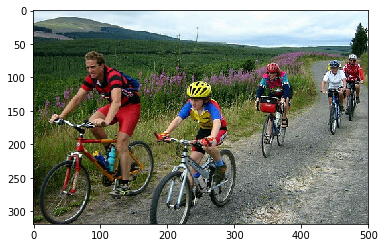

In [7]:
input_image=255*caffe.io.load_image(_INPUT_FILE)
input_image=resize_image(input_image) # Resize the image while preseving the aspect ratio
image=PILImage.fromarray(np.uint8(input_image))
image=np.array(image)
plt.imshow(image)# visualize the input image

In [8]:
mean_vec=np.array([123.68,116.779,103.939])
mean_vec=mean_vec.reshape(1,1,3)

im=image[:,:,::-1] # convert RGB Image to BGR Image
im=im.astype(np.float32) # convert np.uint8 type to np.float32
im=im-mean_vec # subtract the mean image
# Pad zero to the input image to form a square input
cur_h,cur_w,cur_c=im.shape
pad_h=_MAX_DIM-cur_h
pad_w=_MAX_DIM-cur_w
im=np.pad(im,pad_width=((0,pad_h),(0,pad_w),(0,0)),mode='constant',constant_values=0)
inputs=[im]

### Run the inference on input images

In [9]:
num_images=len(inputs)
num_channels=inputs[0].shape[2]
assert num_channels==3,"Unexpected channel count. A 3-channel RGB image is expected"

caffe_in = np.zeros((num_images,num_channels,_MAX_DIM,_MAX_DIM),dtype=np.float32)
for ix, in_ in enumerate(inputs):
    caffe_in[ix]=in_.transpose((2,0,1))
out=net.forward_all(**{net.inputs[0]:caffe_in})

predictions=out[net.outputs[0]]
segmentation_prediction = predictions[0].argmax(axis=0).astype(np.uint8)
segmentation_prediction = segmentation_prediction[0:cur_h, 0:cur_w]

### Visualize the semantic image segmentation results with PASCAL VOC Color encoder

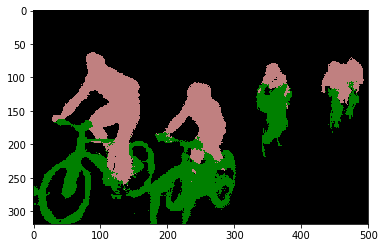

In [10]:
palette=get_palette(256)
output_im = PILImage.fromarray(segmentation_prediction)
output_im.putpalette(palette)
plt.imshow(output_im)